In [1]:
%reset



In [2]:
import os
import struct
import numpy as np
def load_mnist(path:str,kind:str="train")->np.array:
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' % kind)
    with open(labels_path,'rb') as lbpath:
        magic,n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    with open(images_path,'rb') as imgpath:
        magic,n,rows,cols=struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape((len(labels),784))
        images = ((images/255.)-.5)
    return images,labels
X_train,y_train = load_mnist('', kind='byte_files/train')
X_train.shape

(60000, 784)

In [3]:
X_test,y_test = load_mnist('', kind='byte_files/test')

In [4]:
X_test

array([[-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       ...,
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5]])

In [5]:
X_train[y_train==1][0].reshape(28,28)

array([[-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5       , -0.5       , -0.5       , -0.5       ,
        -0.5       , -0.5   

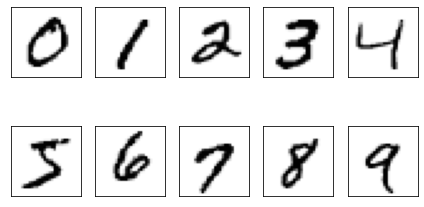

In [6]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)

ax=ax.flatten()
for i in range(10):
    img =X_train[y_train==i][0].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

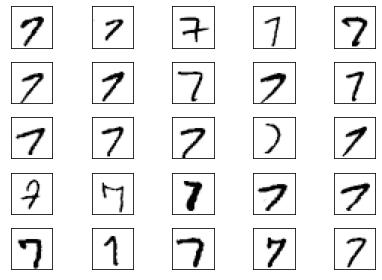

In [7]:
fig,ax = plt.subplots(
    nrows=5,
    ncols=5,
    sharey=True,
    sharex=True
)
ax=ax.flatten()
for i in range(25):
    img =X_train[y_train==7][i].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [8]:
"""Компресс датасета в архив"""
np.savez_compressed("mnist_scaled.npz",
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)


In [9]:
"""чтение архива npz"""
mnist=np.load("mnist_scaled.npz")
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [10]:
X_train=mnist['X_train']
X_train

array([[-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       ...,
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5]])

In [11]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train',
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

In [12]:
import sys
class NeuralNetMlp(object):
    """Нейронная сетья прямого распространения на основе классификатора
    многослойного персептрона
    Параметры
    ----------
    n_hidden : int (по умолчанию: 30)
        количество скрытых элементов

    l2 : float ( по умолчанию 0.)
        значение l2  регуляризации лямбда

    epochs : int (по умолчанию : 100)
        количество подходов к обучающему образцу

    eta : float (по умолчанию 0.001)
        скорость обучения
    shuffle : bool (по умолчанию True)
        тасовка входных данных
    minibatch_size : int( по умолчанию 1)
        Количество обучающих образцов на мини пакет
    seed : int (по умолчанию None)
        Случайные начальные значения для инициализации весов

    Атрибуты
    ---------
    eval_: dict
        словарь, в котором собираются показатели издержек,
        правильности при обучении и правильности при испытании
        для каждой эпохи во время обучения
        """

    def __init__(self, n_hidden=30, l2=0.,epochs=100,
                 eta=0.001, shuffle=True,minibatch_size=1, seed=None):
        self.random=np.random.RandomState(seed)
        self.n_hidden=n_hidden
        self.l2=l2
        self.epochs=epochs
        self.eta=eta
        self.shuffle=shuffle
        self.minibatch_size=minibatch_size

    def _onehot(self,y,n_classes):
        """кодирует метки с унитарным кодом"""

        onehot=np.zeros((n_classes,y.shape[0]))
        for idx,val in enumerate(y.astype(int)):
            onehot[val,idx]=1.
        return onehot.T

    def _sigmoid(self,z):
        return 1./(1.+np.exp(-np.clip(z,-250,250)))

    def _forward(self,X):
        # шаг 1 : общий вход скрытого слоя
        # скалярное произведение {n_examples, n_features}
        # и {n_features, n_hidden}
        # -> {n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        #шаг 2: активация скрытого слоя
        a_h = self._sigmoid(z_h)
        # шаг 3: общий вход выходного слоя
        # скалярное произведение {n_examples, n_hidden}
        # и [n_hidden, п classlabels}
        # -> [n_examples, n_classlabels]
        z_out=np.dot(a_h,self.w_out)+self.b_out
        # шаг 4: активация выходного слоя
        a_out=self._sigmoid(z_out)
        return z_h,a_h,z_out,a_out

    def _compute_cost(self,y_enc,output):
        L2_term = (self.l2 *
                   (np.sum(self.w_h**2.)+np.sum(self.w_out**2.)))
        term1=-y_enc*(np.log(output))
        term2=(1.-y_enc)*np.log(1.-output)
        cost=np.sum(term1-term2)+L2_term
        return cost

    def predict(self,X):
        z_h,a_h,z_out,a_out=self._forward(X)
        y_pred=np.argmax(z_out,axis=1)
        return y_pred

    def fit(self,X_train,y_train,X_valid,y_valid):

        """инициализация"""
        n_output=np.unique(y_train).shape[0]
        n_features=X_train.shape[1]

        self.b_h=np.zeros(self.n_hidden)
        self.w_h=self.random.normal(loc=0.0,scale=0.1,
                                 size=(n_features,self.n_hidden))
        self.b_out=np.zeros(n_output)
        self.w_out=self.random.normal(loc=0.0,scale=0.1,
                                 size=(self.n_hidden,n_output))
        epoch_strlen=len(str(self.epochs))
        self.eval_={'cost':[],'train_acc':[],'valid_acc':[]}
        y_train_enc=self._onehot(y_train,n_output)

        for i in range(self.epochs):
            indices=np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0]- self.minibatch_size+
                                   1,self.minibatch_size):

                batch_idx=indices[start_idx:start_idx+self.minibatch_size]

                """прямое распространение"""
                z_h,a_h,z_out,a_out=self._forward(X_train[batch_idx])

                """обратное  распространение"""
                delta_out=a_out-y_train_enc[batch_idx]

                sigmoid_derivative_h=a_h*(1.-a_h)

                delta_h=(np.dot(delta_out,self.w_out.T)*sigmoid_derivative_h)

                grad_w_h=np.dot(X_train[batch_idx].T,delta_h)
                grad_b_h=np.sum(delta_h,axis=0)

                grad_w_out=np.dot(a_h.T,delta_out)
                grad_b_out=np.sum(delta_out,axis=0)

                delta_w_h=(grad_w_h + self.l2*self.w_h)
                delta_b_h=grad_b_h
                self.w_h-=self.eta*delta_w_h
                self.b_h-=self.eta*delta_b_h

                delta_w_out=(grad_w_out+self.l2*self.w_out)
                delta_b_out=grad_b_out
                self.w_out-=self.eta*delta_w_out
                self.b_out-=self.eta*delta_b_out

            """оценка"""
            z_h,a_h,z_out,a_out=self._forward(X_train)
            cost=self._compute_cost(y_enc=y_train_enc,output=a_out)
            y_train_pred=self.predict(X_train)
            y_valid_pred=self.predict(X_valid)
            train_acc=((np.sum(y_train==y_train_pred)).astype(np.float) /
                       X_train.shape[0])

            valid_acc=((np.sum(y_valid==y_valid_pred)).astype(np.float) /
                       X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                         '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                         (epoch_strlen, i+1, self.epochs, cost,
                          train_acc*100, valid_acc*100))
            sys.stderr.flush()
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

nn=NeuralNetMlp(n_hidden=100,l2=0.01,epochs=150,eta=0.0005,minibatch_size=100,shuffle=True,seed=1)

In [13]:
nn.fit(
    X_train=X_train[:55000],
    y_train=y_train[:55000],
    X_valid=X_train[55000:],
    y_valid=y_train[55000:]
)


C:\Users\karim\AppData\Local\Temp/ipykernel_10156/3589704427.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc=((np.sum(y_train==y_train_pred)).astype(np.float) /
C:\Users\karim\AppData\Local\Temp/ipykernel_10156/3589704427.py:145: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc=((np.sum(y_valid==y_valid_pred)).astyp

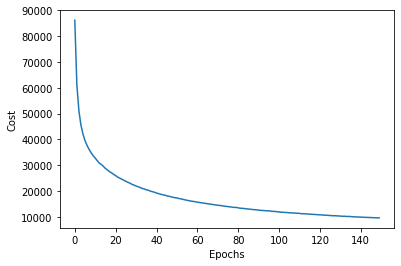

In [14]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

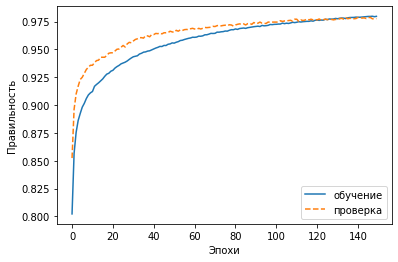

In [15]:
plt.plot(range(nn.epochs),nn.eval_['train_acc'], label='обучение')
plt.plot(range(nn.epochs),nn.eval_['valid_acc'], label='проверка',
         linestyle='--')
plt.ylabel('Правильность')
plt.xlabel('Эпохи')
plt.legend(loc='lower right')
plt.show()



In [16]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test==y_test_pred).astype(np.float)/X_test.shape[0])
print('Правильность при испытании : %.2f%%' %(acc*100))

Правильность при испытании : 97.06%


C:\Users\karim\AppData\Local\Temp/ipykernel_10156/3785581391.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = (np.sum(y_test==y_test_pred).astype(np.float)/X_test.shape[0])


C:\Users\karim\AppData\Local\Temp/ipykernel_10156/3411356004.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  correct_lab=y_test[[y_test!=y_test_pred]][:25]


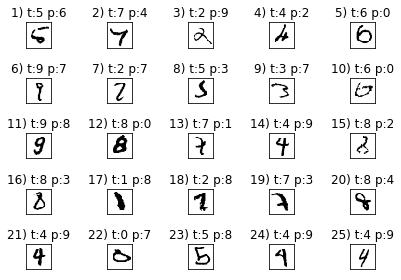

In [17]:
misci_img =X_test[y_test!=y_test_pred][:25]
correct_lab=y_test[[y_test!=y_test_pred]][:25]
misci_lab=y_test_pred[y_test!=y_test_pred][:25]
fig,ax = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(25):
    img=misci_img[i].reshape(28,28)
    ax[i].imshow(img,cmap='Greys',interpolation='nearest')
    ax[i].set_title(f'{i+1}) t:{correct_lab[i]} p:{misci_lab[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import tensorflow as tf
np.set_printoptions(precision=3)
a=np.array([1,2,3,4,5], dtype=np.int32)
b=[6,7,8]
t_a=tf.convert_to_tensor(a)
t_b=tf.convert_to_tensor(b)
print(t_a,t_b)

tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32) tf.Tensor([6 7 8], shape=(3,), dtype=int32)


In [19]:
t_ones=tf.ones((2,3))
t_ones.shape


TensorShape([2, 3])

In [20]:
t_ones.numpy()
#509

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [21]:
t_a_new=tf.cast(t_a,tf.int64) #меняем тип тензора
t_a_new.dtype

tf.int64

In [22]:
t = tf.random.uniform(shape=(3,5))
t

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.222, 0.398, 0.632, 0.56 , 0.842],
       [0.147, 0.838, 0.398, 0.438, 0.224],
       [0.534, 0.765, 0.648, 0.387, 0.248]], dtype=float32)>

In [23]:
tf.transpose(t)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.222, 0.147, 0.534],
       [0.398, 0.838, 0.765],
       [0.632, 0.398, 0.648],
       [0.56 , 0.438, 0.387],
       [0.842, 0.224, 0.248]], dtype=float32)>

In [24]:
# tf.reshape(t,shape=(5,6))

In [25]:
t=tf.zeros((1,2,1,4,1))
tf.squeeze(t,axis=(2,4)) #меняем ращмерность тензора


<tf.Tensor: shape=(1, 2, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.]]], dtype=float32)>

In [26]:
tf.random.set_seed(1)
t1=tf.random.uniform(shape=(5,2), minval=-1.,maxval=1.)
t2=tf.random.normal(shape=(5,2),mean=.0,stddev=1.)
t1

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-0.67 ,  0.803],
       [ 0.262, -0.131],
       [-0.416,  0.285],
       [ 0.952, -0.13 ],
       [ 0.32 ,  0.21 ]], dtype=float32)>

In [27]:
t2

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.403, -1.088],
       [-0.063,  1.337],
       [ 0.712, -0.489],
       [-0.764, -1.037],
       [-1.252,  0.021]], dtype=float32)>

In [28]:
tf.multiply(t1,t2) # умножение тензоров


<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-0.27 , -0.874],
       [-0.017, -0.175],
       [-0.296, -0.139],
       [-0.727,  0.135],
       [-0.401,  0.004]], dtype=float32)>

In [29]:
tf.math.reduce_sum(t2) #сумма

<tf.Tensor: shape=(), dtype=float32, numpy=-2.2211773>

In [30]:
mn1=tf.math.reduce_mean(t1,axis=1)
std1=tf.math.reduce_std(t1,axis=1)
print(t1.numpy())
print(mn1)
print(std1)

[[-0.67   0.803]
 [ 0.262 -0.131]
 [-0.416  0.285]
 [ 0.952 -0.13 ]
 [ 0.32   0.21 ]]
tf.Tensor([ 0.067  0.066 -0.066  0.411  0.265], shape=(5,), dtype=float32)
tf.Tensor([0.736 0.196 0.351 0.541 0.055], shape=(5,), dtype=float32)


In [31]:
print(t1)
print(t2)
print(tf.matmul(t1,t2,transpose_b=True)) #матричное умножение

tf.Tensor(
[[-0.67   0.803]
 [ 0.262 -0.131]
 [-0.416  0.285]
 [ 0.952 -0.13 ]
 [ 0.32   0.21 ]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[ 0.403 -1.088]
 [-0.063  1.337]
 [ 0.712 -0.489]
 [-0.764 -1.037]
 [-1.252  0.021]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[-1.144  1.115 -0.87  -0.321  0.856]
 [ 0.248 -0.191  0.25  -0.064 -0.331]
 [-0.478  0.407 -0.436  0.022  0.527]
 [ 0.525 -0.234  0.741 -0.593 -1.194]
 [-0.099  0.26   0.125 -0.462 -0.396]], shape=(5, 5), dtype=float32)


In [32]:
print(tf.norm(t1,ord=2,axis=1).numpy()) #расчитываем норму L2
print(np.sqrt(np.sum(np.square(t1),axis=1)))

[1.046 0.293 0.504 0.96  0.383]
[1.046 0.293 0.504 0.96  0.383]


In [33]:
t=tf.random.uniform((6,))
t.numpy()

array([0.829, 0.634, 0.515, 0.391, 0.581, 0.048], dtype=float32)

In [34]:
t_splits=tf.split(t,num_or_size_splits=3)#делим тензор на три части
[item.numpy() for item in t_splits]

[array([0.829, 0.634], dtype=float32),
 array([0.515, 0.391], dtype=float32),
 array([0.581, 0.048], dtype=float32)]

In [35]:
t=tf.random.uniform((5,))
t_splits=tf.split(t,num_or_size_splits=(3,2))
print(t.numpy())
print([item.numpy() for item in t_splits])


[0.236 0.239 0.504 0.774 0.611]
[array([0.236, 0.239, 0.504], dtype=float32), array([0.774, 0.611], dtype=float32)]


In [36]:
A=tf.ones((3,))

B=tf.zeros((3,))
C=tf.concat([A,B],axis=0)#соединение тензоров
print(A.numpy())
print(B.numpy())
print(C.numpy())

[1. 1. 1.]
[0. 0. 0.]
[1. 1. 1. 0. 0. 0.]


In [37]:
A=tf.ones((3,))
B=tf.zeros((3,))
tf.stack([A,B],axis=1)#соединение стопкой (как zip)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

In [38]:
"""создание наборов данных из имеющихся структур"""
a=[1.2,3,4,5,5,1,0]
ds=tf.data.Dataset.from_tensor_slices(a)
print(ds)

<TensorSliceDataset shapes: (), types: tf.float32>


In [39]:
for item in ds:
    print(item)


tf.Tensor(1.2, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [40]:
"""создаем пакеты из имеющегося датасета"""
ds_batch=ds.batch(3)#внутри указывается размер каждого пакета
for i,elem in enumerate(ds_batch,1):
    print(f"пакет:{i,elem.numpy()}")

пакет:(1, array([1.2, 3. , 4. ], dtype=float32))
пакет:(2, array([5., 5., 1.], dtype=float32))
пакет:(3, array([0.], dtype=float32))


In [41]:
t_x = tf.random.uniform([4,3], dtype=tf.float32)
t_y = tf.range(4)
print(t_x)
print(t_y)
ds_x=tf.data.Dataset.from_tensor_slices(t_x)
ds_y=tf.data.Dataset.from_tensor_slices(t_y)
ds_joint=tf.data.Dataset.zip((ds_x,ds_y))
for example in ds_joint:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')

tf.Tensor(
[[0.735 0.142 0.063]
 [0.189 0.798 0.704]
 [0.409 0.514 0.072]
 [0.345 0.751 0.153]], shape=(4, 3), dtype=float32)
tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
x example: [0.735 0.142 0.063]
y example: 0 
x example: [0.189 0.798 0.704]
y example: 1 
x example: [0.409 0.514 0.072]
y example: 2 
x example: [0.345 0.751 0.153]
y example: 3 


In [42]:
ds_trans=ds_joint.map(lambda x,y : (x*2-1.,y))

for example in ds_trans:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')

x example: [ 0.47  -0.716 -0.873]
y example: 0 
x example: [-0.622  0.596  0.408]
y example: 1 
x example: [-0.182  0.029 -0.856]
y example: 2 
x example: [-0.309  0.501 -0.693]
y example: 3 


In [43]:
ds=ds_joint.shuffle(buffer_size=len(t_x))#тасует элементы,buffer_size - количество элементов в набое
for example in ds:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')


x example: [0.735 0.142 0.063]
y example: 0 
x example: [0.409 0.514 0.072]
y example: 2 
x example: [0.189 0.798 0.704]
y example: 1 
x example: [0.345 0.751 0.153]
y example: 3 


In [44]:
ds=ds_joint.batch(batch_size=3,drop_remainder=False)
batch_x,batch_y=next(iter(ds))
print(f'Пакет x{batch_x.numpy()}')
print(f'Пакет y{batch_y.numpy()}')


Пакет x[[0.735 0.142 0.063]
 [0.189 0.798 0.704]
 [0.409 0.514 0.072]]
Пакет y[0 1 2]


In [45]:
"""Повтор"""
ds=ds_joint.batch(3).repeat(count=2)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())


0 (3, 3) [0 1 2]
1 (1, 3) [3]
2 (3, 3) [0 1 2]
3 (1, 3) [3]


In [46]:
"""Повтор """
ds=ds_joint.repeat(count=2).batch(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())



0 (3, 3) [0 1 2]
1 (3, 3) [3 0 1]
2 (2, 3) [2 3]


In [47]:
"""тасование создание пакетов повторение"""
ds=ds_joint.shuffle(4).batch(2).repeat(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())

0 (2, 3) [1 2]
1 (2, 3) [0 3]
2 (2, 3) [0 3]
3 (2, 3) [2 1]
4 (2, 3) [2 3]
5 (2, 3) [0 1]


In [48]:
"""создание пакетов тасование  повторение"""
ds=ds_joint.batch(2).shuffle(4).repeat(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())
#520

0 (2, 3) [2 3]
1 (2, 3) [0 1]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]


In [49]:
import pathlib
imdir_path=pathlib.Path('cat_fish')
file_list=sorted([str(path) for path in imdir_path.glob('*.jpg') ])
file_list

['cat_fish\\cat1.jpg',
 'cat_fish\\cat2.jpg',
 'cat_fish\\cat3.jpg',
 'cat_fish\\fish1.jpg',
 'cat_fish\\fish2.jpg',
 'cat_fish\\fish3.jpg']

Размер изображения ('cat_fish\\cat1.jpg', TensorShape([202, 249, 3]))
Размер изображения ('cat_fish\\cat2.jpg', TensorShape([183, 275, 3]))
Размер изображения ('cat_fish\\cat3.jpg', TensorShape([194, 259, 3]))
Размер изображения ('cat_fish\\fish1.jpg', TensorShape([183, 275, 3]))
Размер изображения ('cat_fish\\fish2.jpg', TensorShape([173, 291, 3]))
Размер изображения ('cat_fish\\fish3.jpg', TensorShape([150, 336, 3]))


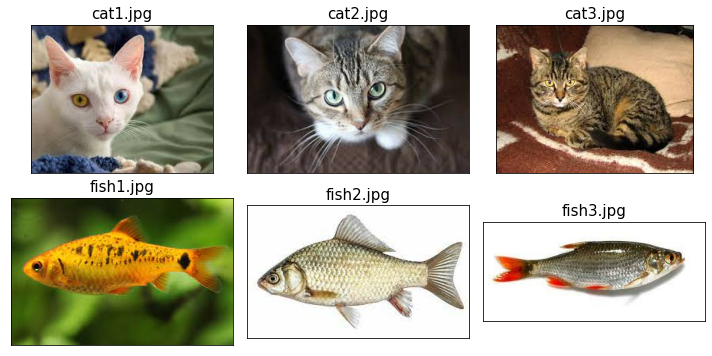

In [50]:
fig=plt.figure(figsize=(10,5))
for i,file in enumerate(file_list):
    img_raw=tf.io.read_file(file)
    img=tf.image.decode_jpeg(img_raw)
    print(f'Размер изображения {file, img.shape}')
    ax=fig.add_subplot(2,3,i+1)
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file),size=15)
plt.tight_layout()
plt.show()


In [51]:
labels=[1 if 'fish' in os.path.basename(file) else 0 for file in file_list]
labels

[0, 0, 0, 1, 1, 1]

In [52]:
"""создаем даасет тензоров совмещенный с метками"""
ds_files_labels=tf.data.Dataset.from_tensor_slices((file_list,labels))
for item in ds_files_labels:
    print(item[0].numpy(),item[1].numpy())

b'cat_fish\\cat1.jpg' 0
b'cat_fish\\cat2.jpg' 0
b'cat_fish\\cat3.jpg' 0
b'cat_fish\\fish1.jpg' 1
b'cat_fish\\fish2.jpg' 1
b'cat_fish\\fish3.jpg' 1


In [53]:
list(ds_files_labels)

[(<tf.Tensor: shape=(), dtype=string, numpy=b'cat_fish\\cat1.jpg'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=0>),
 (<tf.Tensor: shape=(), dtype=string, numpy=b'cat_fish\\cat2.jpg'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=0>),
 (<tf.Tensor: shape=(), dtype=string, numpy=b'cat_fish\\cat3.jpg'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=0>),
 (<tf.Tensor: shape=(), dtype=string, numpy=b'cat_fish\\fish1.jpg'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>),
 (<tf.Tensor: shape=(), dtype=string, numpy=b'cat_fish\\fish2.jpg'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>),
 (<tf.Tensor: shape=(), dtype=string, numpy=b'cat_fish\\fish3.jpg'>,
  <tf.Tensor: shape=(), dtype=int32, numpy=1>)]

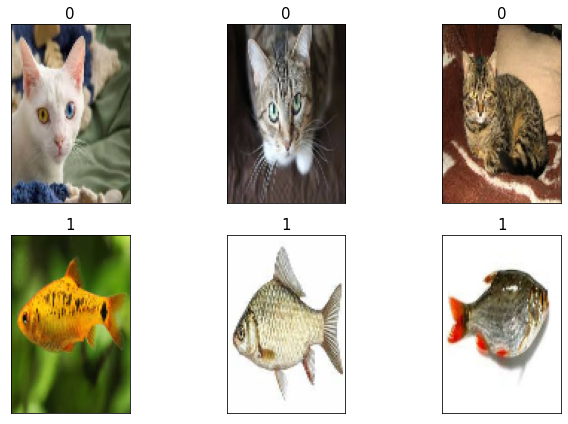

In [54]:
img_height,img_width=120,80
def load_and_process(path:str,label:list):
    """Открывает, обрабатывает, и приводит к одному размеру изображение,
    после нормализует /255"""
    image=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image,channels=3)
    image=tf.image.resize(image,[img_height,img_width])
    image/=255.
    return image,label
ds_images_labels=ds_files_labels.map(load_and_process) #применяет функцию load_and_process к каждой паре изображения и метки датасета
fig=plt.figure(figsize=(10,6))
for i,example in enumerate(ds_images_labels):
    ax=fig.add_subplot(2,3,i+1)
    # print(example,type(example))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title(f'{example[1].numpy()}',size=15)
plt.tight_layout()
plt.show()


In [55]:
import tensorflow_datasets as tfds
tfds.list_builders()


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'cs_restaurants',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adr

In [56]:
"""Метод извлечения набора данных на примере mnist
1.Вызов функции построителя набора данных
2.выполнение метода download_and_prepare()
3.Вызов метода as_dataset()"""

mnist_bldr=tfds.builder('mnist')
mnist_bldr.info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [57]:
mnist_bldr.info.citation

'@article{lecun2010mnist,\n  title={MNIST handwritten digit database},\n  author={LeCun, Yann and Cortes, Corinna and Burges, CJ},\n  journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},\n  volume={2},\n  year={2010}\n}'

In [58]:
mnist,mnist_info=tfds.load('mnist',with_info=True,
                           shuffle_files=False)
mnist_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\karim\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [59]:
mnist.keys()

dict_keys(['train', 'test'])

(10, 28, 28, 1) tf.Tensor([4 1 0 7 8 1 2 7 1 6], shape=(10,), dtype=int64)


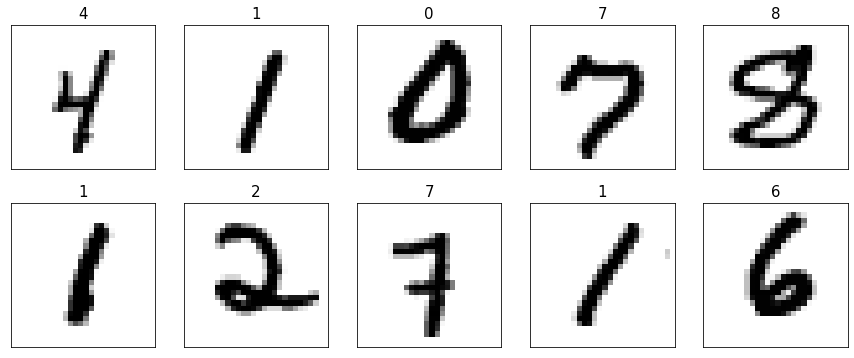

In [60]:
ds_train=mnist['train']
ds_train=ds_train.map(lambda item: (item['image'],item['label']))
ds_train=ds_train.batch(10) #создаем 10 пакетов
batch=next(iter(ds_train))
print(batch[0].shape,batch[1])
fig = plt.figure(figsize=(15,6))
for i,(image,label) in enumerate(zip(batch[0],batch[1])):
    ax=fig.add_subplot(2,5,i+1) #2 ряда 5 колонок
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(image[:,:,0],cmap='gray_r')
    ax.set_title(f'{label}',size=15)
plt.show()


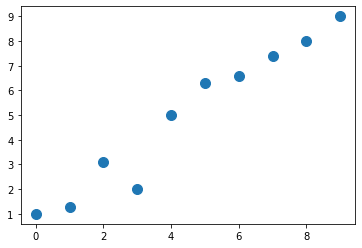

In [61]:
X_train=np.arange(10).reshape((10,1))
y_train=np.array([1.,1.3,3.1,2.,5.,6.3,6.6,7.4,8.,9.])
plt.plot(X_train,y_train,'o',markersize=10)
plt.show()

In [62]:
X_train_norm=(X_train-np.mean(X_train))/np.std(X_train)
ds_train_orig=tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm,tf.float32),
     tf.cast(y_train,tf.float32)))
ds_train_orig


<TensorSliceDataset shapes: ((1,), ()), types: (tf.float32, tf.float32)>

In [63]:
from tensorflow.keras import Model
"""Генерируем ленейную регрессию wx+b"""
class MyModel(Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.w=tf.Variable(0.0,name='weight')
        self.b=tf.Variable(0.0,name='bias')
    def call(self, x):
        return self.w*x+self.b

model=MyModel()
model.build(input_shape=(None,1)) # None - заполнитель первого измерения входного тензора, что позволяет использовать произвольный размер пакета. Количество признаков - 1
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [64]:
def loss_fn(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_true-y_pred))
def train(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as tape :
        current_loss=loss_fn(model(inputs),outputs)
    dW,db=tape.gradient(current_loss,[model.w,model.b])
    model.w.assign_sub(learning_rate*dW)
    model.b.assign_sub(learning_rate*db)
tf.random.set_seed(1)
num_epochs=200
log_steps=100
learning_rate=0.001
batch_size=1
steps_per_epoch=int(np.ceil(len(y_train)/batch_size))
ds_train=ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train=ds_train.repeat(count=None) #if none infinit repeats
ds_train=ds_train.batch(1)
Ws,bs=[],[]
for i,batch in enumerate(ds_train):
    if i>=steps_per_epoch*num_epochs:
        #прекратить бесконечный цикл повторений
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    bx,by=batch
    loss_val=loss_fn(model(bx),by)

    train(model,bx,by,learning_rate=learning_rate)
    if i%log_steps==0:
        print(f'Эпоха: {int(i/steps_per_epoch)},Шаг: {i},Потеря: {loss_val}')

Эпоха: 0,Шаг: 0,Потеря: 43.55999755859375
Эпоха: 10,Шаг: 100,Потеря: 0.7530134320259094
Эпоха: 20,Шаг: 200,Потеря: 20.175859451293945
Эпоха: 30,Шаг: 300,Потеря: 23.397605895996094
Эпоха: 40,Шаг: 400,Потеря: 6.348119258880615
Эпоха: 50,Шаг: 500,Потеря: 4.635603427886963
Эпоха: 60,Шаг: 600,Потеря: 0.24105073511600494
Эпоха: 70,Шаг: 700,Потеря: 0.20362770557403564
Эпоха: 80,Шаг: 800,Потеря: 3.8176910877227783
Эпоха: 90,Шаг: 900,Потеря: 0.9416388869285583
Эпоха: 100,Шаг: 1000,Потеря: 0.7034985423088074
Эпоха: 110,Шаг: 1100,Потеря: 0.034772761166095734
Эпоха: 120,Шаг: 1200,Потеря: 0.5403661131858826
Эпоха: 130,Шаг: 1300,Потеря: 0.11702598631381989
Эпоха: 140,Шаг: 1400,Потеря: 0.11948295682668686
Эпоха: 150,Шаг: 1500,Потеря: 0.09437620639801025
Эпоха: 160,Шаг: 1600,Потеря: 0.4670370817184448
Эпоха: 170,Шаг: 1700,Потеря: 2.0694775581359863
Эпоха: 180,Шаг: 1800,Потеря: 0.001972649712115526
Эпоха: 190,Шаг: 1900,Потеря: 0.3612426519393921


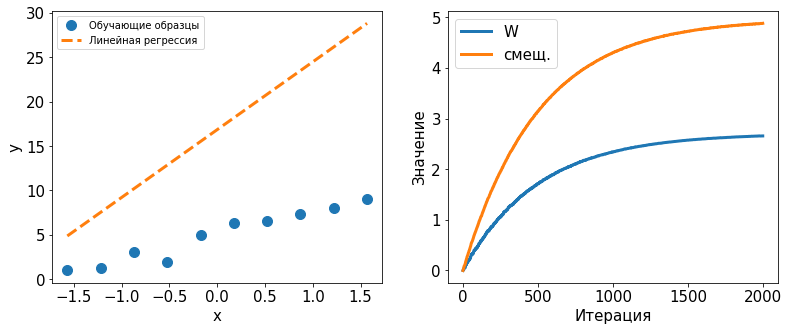

In [65]:
X_test=np.linspace(0,9,num=100).reshape(-1,1)
X_test_norm=(X_test-np.mean(X_train))/np.std(X_train)
y_pred=model(tf.cast(X_test,tf.float32))
fig=plt.figure(figsize=(13,5))
ax=fig.add_subplot(1,2,1)
plt.plot(X_train_norm,y_train,'o',markersize=10)
plt.plot(X_test_norm,y_pred,'--',lw=3)
plt.legend(['Обучающие образцы','Линейная регрессия'])
ax.set_xlabel('x',size=15)
ax.set_ylabel('y',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
plt.plot(Ws,lw=3)
plt.plot(bs,lw=3)
plt.legend(['W','смещ.'],fontsize=15)
ax.set_xlabel('Итерация',size=15)
ax.set_ylabel('Значение',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()

In [66]:
tf.random.set_seed(1)
model=MyModel()
model.compile(optimizer='sgd',loss=loss_fn,metrics=['mae','mse'])
model.fit(X_train_norm,y_train,epochs=num_epochs,batch_size=batch_size,
          verbose=1)

Epoch 1/200
10/10 [==============================] - 0s 1ms/step - loss: 27.8723 - mae: 4.5654 - mse: 27.8723
Epoch 2/200
10/10 [==============================] - 0s 778us/step - loss: 18.6586 - mae: 3.7446 - mse: 18.6586
Epoch 3/200
10/10 [==============================] - 0s 777us/step - loss: 12.5239 - mae: 3.0454 - mse: 12.5239
Epoch 4/200
10/10 [==============================] - 0s 1000us/step - loss: 8.4670 - mae: 2.4907 - mse: 8.4670
Epoch 5/200
10/10 [==============================] - 0s 741us/step - loss: 5.7632 - mae: 2.0567 - mse: 5.7632
Epoch 6/200
10/10

In [67]:
iris,iris_info=tfds.load('iris',with_info=True)
print(iris_info)


tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='C:\\Users\\karim\\tensorflow_datasets\\iris\\2.0.0',
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_

In [68]:
"""Расщепление данных на тренировочные и тестовые наборы с тасовкой"""
tf.random.set_seed(1)
ds_orig=iris['train']
ds_orig=ds_orig.shuffle(150,reshuffle_each_iteration=False)
ds_train_orig=ds_orig.take(100)
ds_test=ds_orig.skip(100)
print(ds_train_orig)
print(ds_test)

<TakeDataset shapes: {features: (4,), label: ()}, types: {features: tf.float32, label: tf.int64}>
<SkipDataset shapes: {features: (4,), label: ()}, types: {features: tf.float32, label: tf.int64}>


In [69]:
for i in ds_train_orig:
    print(i.keys())
    print(i['features'].numpy(),i['features'].numpy().shape)
    print(i['label'].numpy())
    break

dict_keys(['features', 'label'])
[6.5 3.  5.2 2. ] (4,)
2


In [70]:
"""трансформируем словарь в кортеж"""
ds_train_orig=ds_train_orig.map(lambda x: (x['features'],x['label']))
ds_test=ds_test.map(lambda x: (x['features'],x['label']))
ds_train_orig

<MapDataset shapes: ((4,), ()), types: (tf.float32, tf.int64)>

In [71]:
"""Dense - полносвязный слой(линейный) лучше всего может быть представлен в виде
f(w*x+b), x - входные признаки, w и b - матрицы весов и смещений"""
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
iris_model=Sequential()
iris_model.add(Dense(16,activation='sigmoid',name='fc1',
               input_shape=(4,)))#Принимаем на вход данные из 4 признаков(смотри размерность массива features) и передаем их на расчет 16 нейронам по функции сигмоида
iris_model.add(Dense(3,name='fc2',activation='softmax'))#принимает на вход выход предыдущего слоя(16) и проецирует на 3 нейрона(так как три метки классов - смотри label массива)
iris_model.summary()
"""формула расчета параметров (n_in+1)*n_out,
при этом матрица весов w размера n_in*n_out,и матрица
смещения b размера n_out"""


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


'формула расчета параметров (n_in+1)*n_out,\nпри этом матрица весов w размера n_in*n_out,и матрица\nсмещения b размера n_out'

In [72]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
num_epochs=100
training_size=100
batch_size=2
steps_per_epoch=np.ceil(training_size/batch_size)
ds_train=ds_train_orig.shuffle(buffer_size=training_size)
ds_train=ds_train.repeat()
ds_train=ds_train.batch(batch_size=batch_size)
ds_train=ds_train.prefetch(buffer_size=1000)
ds_train

<PrefetchDataset shapes: ((None, 4), (None,)), types: (tf.float32, tf.int64)>

In [73]:
history=iris_model.fit(ds_train,epochs=num_epochs,steps_per_epoch=steps_per_epoch,
                       verbose=0)

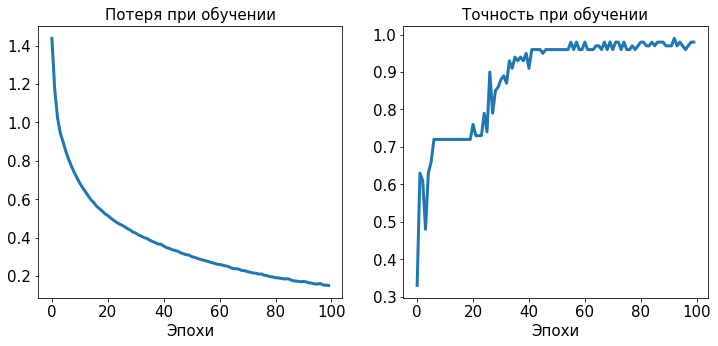

In [74]:
hist=history.history
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.set_title('Потеря при обучении',size=15)
ax.set_xlabel('Эпохи',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.set_title('Точность при обучении',size=15)
ax.set_xlabel('Эпохи',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()

In [75]:
print("Текущий размер",len(list(ds_test.as_numpy_iterator())))
for i in ds_test.batch(50):
    print(i[0].numpy(),i[0].numpy().shape)
    print(i[1].numpy())

Текущий размер 50
[[5.7 2.5 5.  2. ]
 [7.2 3.6 6.1 2.5]
 [5.3 3.7 1.5 0.2]
 [5.5 2.4 3.8 1.1]
 [6.4 3.1 5.5 1.8]
 [5.8 4.  1.2 0.2]
 [5.6 2.5 3.9 1.1]
 [6.1 2.6 5.6 1.4]
 [5.1 3.5 1.4 0.3]
 [5.6 2.8 4.9 2. ]
 [5.6 2.7 4.2 1.3]
 [7.2 3.2 6.  1.8]
 [5.7 2.8 4.1 1.3]
 [6.9 3.1 5.4 2.1]
 [4.8 3.1 1.6 0.2]
 [4.8 3.  1.4 0.3]
 [6.1 3.  4.9 1.8]
 [5.2 3.5 1.5 0.2]
 [5.4 3.9 1.3 0.4]
 [5.5 3.5 1.3 0.2]
 [5.7 2.9 4.2 1.3]
 [6.6 3.  4.4 1.4]
 [5.6 3.  4.5 1.5]
 [6.2 2.9 4.3 1.3]
 [4.8 3.  1.4 0.1]
 [5.1 2.5 3.  1.1]
 [5.6 3.  4.1 1.3]
 [5.  2.3 3.3 1. ]
 [6.4 3.2 5.3 2.3]
 [6.4 2.9 4.3 1.3]
 [5.1 3.4 1.5 0.2]
 [5.4 3.  4.5 1.5]
 [7.  3.2 4.7 1.4]
 [4.5 2.3 1.3 0.3]
 [5.6 2.9 3.6 1.3]
 [6.3 3.3 4.7 1.6]
 [6.7 3.3 5.7 2.1]
 [5.7 2.8 4.5 1.3]
 [6.9 3.1 4.9 1.5]
 [5.4 3.4 1.5 0.4]
 [6.3 2.5 4.9 1.5]
 [5.  3.3 1.4 0.2]
 [5.7 3.  4.2 1.2]
 [6.3 2.8 5.1 1.5]
 [7.3 2.9 6.3 1.8]
 [5.5 2.4 3.7 1. ]
 [4.7 3.2 1.3 0.2]
 [6.3 2.9 5.6 1.8]
 [5.  3.  1.6 0.2]
 [5.7 2.6 3.5 1. ]] (50, 4)
[2 2 0 1 2 0 1 2 0 2 1 

In [76]:
results=iris_model.evaluate(ds_test.batch(1),verbose=0) #batch увеличивает ранг тензоров на 1, в данном случае 1 пакет размером 50
print(f'Размер ошибки: {results[0]} \nТочность: {results[1]}')

Размер ошибки: 0.14832532405853271 
Точность: 0.9800000190734863


In [77]:
"""сохранение и загрузка обученной модели"""
iris_model.save('iris_classifier.h5',overwrite=True,
                include_optimizer=True,save_format='h5')


In [78]:
loaded_model=tf.keras.models.load_model('iris_classifier.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [79]:
results=loaded_model.evaluate(ds_test.batch(1),verbose=1)
print(f'Размер ошибки: {results[0]} \nТочность: {results[1]}')


50/50 [==============================] - 0s 592us/step - loss: 0.1483 - accuracy: 0.9800
Размер ошибки: 0.14832532405853271 
Точность: 0.9800000190734863


In [80]:
tf.expand_dims

<function tensorflow.python.ops.array_ops.expand_dims_v2(input, axis, name=None)>

In [81]:
model=Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(32,activation='relu'))
model.build(input_shape=(None,4))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


In [82]:
for i in model.variables:
    print(f'{i.name}, {i.trainable}, {i.shape}')


dense/kernel:0, True, (4, 16)
dense/bias:0, True, (16,)
dense_1/kernel:0, True, (16, 32)
dense_1/bias:0, True, (32,)


In [ ]:
"""Для двоичной классификации"""
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.Accuracy(),
                       tf.metrics.Precision(),
                       tf.metrics.Recall()])


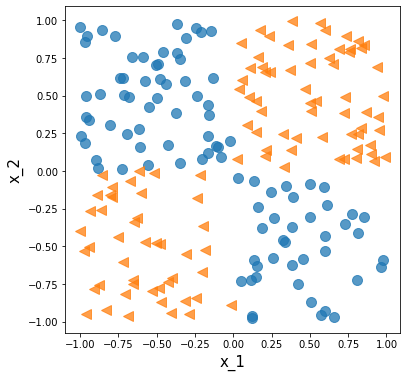

In [114]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
tf.random.set_seed(1)
np.random.seed(1)
x=np.random.uniform(low=-1,high=1,size=(200,2))
y=np.ones(len(x))
y[x[:,0]*x[:,1]<0]=0
x_train=x[:100,:]
y_train=y[:100]
x_valid=x[100:,:]
y_valid=y[100:]
fig=plt.figure(figsize=(6,6))
plt.plot(x[y==0,0],x[y==0,1],'o',alpha=0.75,markersize=10)
plt.plot(x[y==1,0],x[y==1,1],'<',alpha=0.75,markersize=10)
plt.xlabel('x_1',size=15)
plt.ylabel('x_2',size=15)
plt.show()

In [89]:
x.shape

(200, 2)

In [115]:
"""Лог регрессия"""
model=Sequential()
model.add(Dense(1,input_shape=(2,),activation='sigmoid'))
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [116]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,validation_data=(x_valid,y_valid),
               epochs=200,batch_size=2,verbose=0)


C:\Users\karim\AppData\Local\Temp/ipykernel_10156/2331985429.py:20: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)


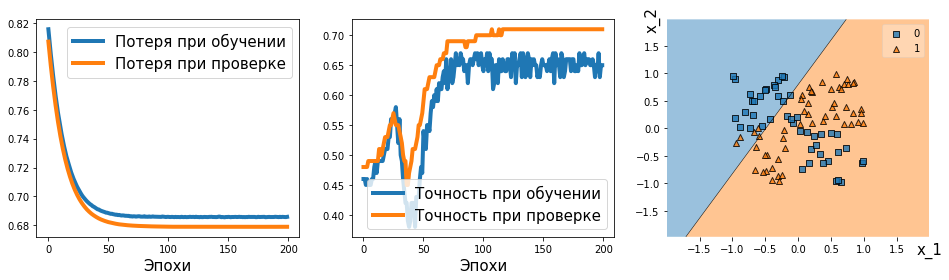

In [119]:
from mlxtend.plotting import plot_decision_regions

history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [126]:
"""Моё решение"""
model=Sequential()
model.add(Dense(4,input_shape=(2,),activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


In [127]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,validation_data=(x_valid,y_valid),
               epochs=200,batch_size=2,verbose=0)

C:\Users\karim\AppData\Local\Temp/ipykernel_10156/2331985429.py:20: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)


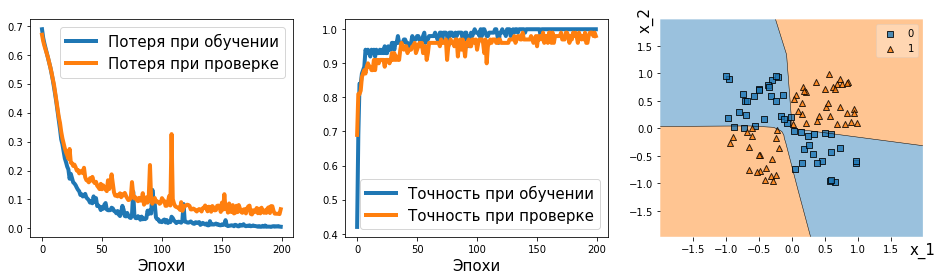

In [128]:
from mlxtend.plotting import plot_decision_regions

history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [134]:
"""пример создания сложных моделей по апи керас"""
#input layer
inputs=tf.keras.Input(shape=(2,))

#hidden layers
h1=Dense(4,input_shape=(2,),activation='relu')(inputs)
h2=Dense(8,activation='relu')(h1)
h3=Dense(8,activation='relu')(h2)
h4=Dense(4,activation='relu')(h3)

#outputs
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(h4)

#constructing
model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_55 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 5         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_____________________________________________________________

In [138]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(x_train,y_train,
          validation_data=(x_valid,y_valid),
          epochs=200,batch_size=2,verbose=0)


In [142]:
"""аналог создания той же модели, но через класс"""
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.hidden1=Dense(4,input_shape=(2,),activation='relu')
        self.hidden2=Dense(8,activation='relu')
        self.hidden3=Dense(8,activation='relu')
        self.hidden4=Dense(4,activation='relu')
        self.output_layer=Dense(1,activation='sigmoid')
    def call(self,inputs):
        h=self.hidden1(inputs)
        h=self.hidden2(h)
        h=self.hidden3(h)
        h=self.hidden4(h)

        return self.output_layer(h)
model=MyModel()
model.build(input_shape=(None,2))
model.summary()

Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             multiple                  12        
_________________________________________________________________
dense_69 (Dense)             multiple                  40        
_________________________________________________________________
dense_70 (Dense)             multiple                  72        
_________________________________________________________________
dense_71 (Dense)             multiple                  36        
_________________________________________________________________
dense_72 (Dense)             multiple                  5         
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


In [158]:
"""Создадим свой кастомный слой w(x+e)+b,
где е - случайный шум"""
class NoisyLayer(tf.keras.layers.Layer):
    def __init__(self,output_dim,noise_stddev=0.1,**kwargs):
        self.output_dim=output_dim
        self.noise_stddev=noise_stddev
        super(NoisyLayer,self).__init__(**kwargs)
    def build(self,input_shape):
        self.w=self.add_weight(name='weights',shape=(input_shape[1],self.output_dim),
                               initializer='random_normal',trainable=True)
        self.b=self.add_weight(shape=(self.output_dim,),initializer='zeros',
                               trainable=True)
    def call(self,inputs,training=False):
        if training:
            batch=tf.shape(inputs)[0]
            dim=tf.shape(inputs)[1]
            noise=tf.random.normal(shape=(batch,dim),mean=0.0,stddev=self.noise_stddev) #добавляем случайный шум е
            noisy_inputs=tf.add(inputs,noise)
        else:
            noisy_inputs=inputs
        z=tf.matmul(noisy_inputs,self.w)+self.b
        return tf.keras.activations.relu(z)
    def get_config(self):
        config=super(NoisyLayer,self).get_config()
        config.update({'output_dim':self.output_dim,
                       'noise_stddev':self.noise_stddev})
        return config
# tf.random.set_seed(1)
# n_l=NoisyLayer(4)
# n_l.build(input_shape=(None,4))
# x=tf.zeros(shape=(1,4))
# tf.print(n_l(x,training=True))

In [150]:
#значания отличиаются из за входного шума
# config=n_l.get_config()
# new_layer=NoisyLayer.from_config(config)
# tf.print(new_layer(x,training=True))

[[0 0.0108502861 0 0]]


In [159]:
model=Sequential()
model.add(NoisyLayer(4,noise_stddev=0.1))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.build(input_shape=(None,2))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noisy_layer_10 (NoisyLayer)  (None, 4)                 12        
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_83 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [160]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,
          validation_data=(x_valid,y_valid),
          epochs=200,batch_size=2,verbose=0)



C:\Users\karim\AppData\Local\Temp/ipykernel_10156/2991864140.py:18: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)


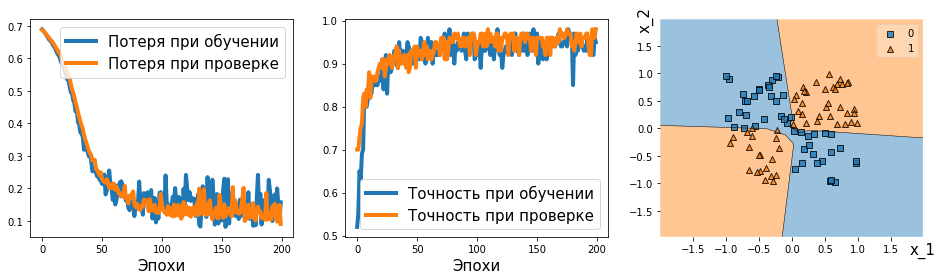

In [161]:
history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [162]:
import pandas as pd
dataset_path=tf.keras.utils.get_file(
    "auto-mpg.data",("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
)
column_name=['MPG','Cylinders','Displacement','Horsepower',
             'Weight','Acceleration','ModelYear','Origin']
df=pd.read_csv(dataset_path,names=column_name,
               na_values='?',comment='\t',
               sep=' ',skipinitialspace=True)
df.dropna()
df=df.reset_index(drop=True)

40960/30286 [========================================] - 0s 0us/step


In [168]:
import sklearn
from sklearn.model_selection import train_test_split

df_train,df_test=train_test_split(df,train_size=0.8)
train_stats=df_train.describe().transpose()
numeric_column_names=['Cylinders','Displacement','Horsepower',
             'Weight','Acceleration']
df_train_norm,df_test_norm=df_train.copy(),df_test.copy()
for col_name in numeric_column_names:
    mean=train_stats.loc[col_name,'mean']
    std=train_stats.loc[col_name,'std']
    df_train_norm.loc[:,col_name]=(df_train_norm.loc[:,col_name]-mean)/std
    df_test_norm.loc[:,col_name]=(df_test_norm.loc[:,col_name]-mean)/std
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
284,20.6,0.304819,0.284405,0.119801,0.441408,0.404974,79,1
95,12.0,1.486921,2.508797,3.129932,2.323988,-1.654356,73,1
344,39.0,-0.877284,-1.059901,-1.084251,-1.315746,0.331426,81,1
104,12.0,1.486921,1.976877,1.611779,2.270741,-1.102750,73,1
371,29.0,-0.877284,-0.586009,-0.560750,-0.546622,0.184331,82,1


In [167]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [177]:
"""столбцы флоат будут образовывать непрерывные признаки,
feature_column преобразует непрерывные признаки  в структуру
данных столбец признаков"""
numeric_features=[]
for col_name in numeric_column_names:
    numeric_features.append(
        tf.feature_column.numeric_column(key=col_name)
    )
numeric_features

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [185]:
df.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear', 'Origin'],
      dtype='object')

In [188]:
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [189]:
feature_years=tf.feature_column.numeric_column(key='ModelYear')
bucketized_features=[]
bucketized_features.append(
    tf.feature_column.bucketized_column(
        source_column=feature_years,
        boundaries=[73,76,79]
    )
)
feature_origin=tf.feature_column.categorical_column_with_vocabulary_list(
    key='Origin',
    vocabulary_list=[1,2,3]
)
categorical_indicator_features=[]
categorical_indicator_features.append(
    tf.feature_column.indicator_column(feature_origin)
)

In [ ]:
#596

In [196]:
import tensorflow_datasets as tfds
tfds.list_builders()


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'cs_restaurants',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adr